# Model selection for DGA-Detector


In [ ]:
"""
 * @file DGA-Detector-Model-Selection.ipynb
 * @brief Evaluates multiple machine learning models for detecting domain generation algorithms (DGA).
 *
 * This notebook details the process of loading and preprocessing data, followed by evaluating 
 * different machine learning models to identify the best-performing one for detecting DGA activity. 
 * Models such as Logistic Regression, SVM, Decision Trees, Random Forest, AdaBoost, XGBoost, 
 * LightGBM, and Neural Networks are evaluated using various metrics. The results are visualized 
 * and compared to select the most suitable model based on accuracy, precision, recall, and computational 
 * efficiency. The notebook serves as an experimental setup for refining and selecting models before 
 * deployment, contributing to a DGA-Detector designed to enhance 
 * network security by effectively identifying and responding to DGA-based threats.
 *
 * The main functionalities include:
 * - Data loading and preprocessing including normalization and train-test splitting.
 * - Model initialization and parameter tuning.
 * - Performance evaluation using metrics like F1 score, ROC-AUC, etc.
 * - Visual comparison of performance metrics across different models.
 * - Selection of optimal model based on performance and operational criteria.
 *
 * @version 1.0
 * @date 2024-03-22
 * @author Matej Keznikl (matej.keznikl@gmail.com)
 * @copyright Copyright (c) 2024
 *
"""

## Loading data

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

dga = pq.read_table("floor/02-Preprocessed-data/DGA/01-DGA-Features.parquet")
benign = pq.read_table("floor/02-Preprocessed-data/Benign/00-Benign-Features.parquet")

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(dga.schema)

dga = dga.append_column("label", pa.array(["dga"] * len(dga)))
benign = benign.append_column("label", pa.array(["benign"] * len(benign)))

dga = dga.drop(["domain_name"])
benign = benign.drop(["domain_name"])

# concatentate tables
data = pa.concat_tables([dga, benign])
df = data.to_pandas()

# Handle NaNs
df.fillna(-1, inplace=True)

df

,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,...,mod_jaccard_tri-grams_benign,mod_jaccard_penta-grams_benign,mod_jaccard_bi-grams_dga,mod_jaccard_tri-grams_dga,mod_jaccard_penta-grams_dga,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_shortest_sub_len,label
0,15,0,0,2,2,0.0000,12,0.237949,0.0,0.000000,...,0.538462,0.000000,0.857143,0.076923,0.000000,7.000000,0.500000,12,12,dga
1,31,1,0,2,3,0.0081,27,0.151053,9.0,0.333333,...,0.172414,0.000000,0.900000,0.137931,0.074074,15.000000,0.500000,27,27,dga
2,19,0,0,1,3,0.6554,15,0.221549,0.0,0.000000,...,0.411765,0.133333,0.888889,0.529412,0.000000,9.000000,0.500000,15,15,dga
3,13,0,1,1,4,0.0043,8,0.375000,0.0,0.000000,...,0.454545,0.222222,0.833333,0.272727,0.111111,6.000000,0.500000,8,8,dga
4,30,1,0,1,3,0.0081,26,0.165993,8.0,0.307692,...,0.142857,0.000000,0.689655,0.107143,0.000000,14.500000,0.500000,26,26,dga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691813,15,0,0,2,10,0.0000,4,0.375000,0.0,0.000000,...,0.615385,0.454545,0.714286,0.076923,0.000000,4.333333,0.528321,7,4,benign
691814,30,0,0,2,5,0.0000,8,0.343750,0.0,0.000000,...,0.714286,0.307692,0.862069,0.285714,0.000000,9.333333,0.528321,15,23,benign
691815,9,0,0,2,2,0.0000,6,0.375272,0.0,0.000000,...,0.571429,0.000000,0.750000,0.142857,0.000000,4.000000,0.500000,6,6,benign
691816,7,0,0,3,3,0.0000,3,0.000000,0.0,0.000000,...,0.400000,0.000000,0.800000,0.000000,0.000000,3.000000,0.000000,3,3,benign


## Subsampling the dataset


In [2]:
subsample = 1  # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.*")
warnings.filterwarnings(
    "ignore", message="Series.__getitem__ treating keys as positions is deprecated.*"
)
warnings.filterwarnings("ignore", category=FutureWarning)

## Train-Test Split


In [4]:
from sklearn.model_selection import train_test_split

class_map = {"benign": 0, "dga": 1}

labels = df["label"].apply(lambda x: class_map[x])  # y vector
features = df.drop("label", axis=1).copy()  # X matrix

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

## Generate seeds


In [5]:
import random


def generate_random_seeds(
    base_seed=None, count=1, lower_bound=0, upper_bound=65535, deterministic=False
):
    """
    Generate a list of pseudorandom seeds.

    Parameters:
        base_seed (int, optional): Seed for the random number generator to ensure repeatability. Default is None.
        count (int): Number of random seeds to generate. Must be positive.
        lower_bound (int): Lower bound of the random number range. Default is 0.
        upper_bound (int): Upper bound of the random number range. Default is 65535.
        deterministic (bool): If True, use a deterministic pseudo-random generator; otherwise, use the system's random source. Default is False.

    Returns:
        list of int: A list containing the generated random seeds.

    Raises:
        ValueError: If `count`, `lower_bound`, or `upper_bound` are not correctly specified.
    """
    if count < 1:
        raise ValueError("Count must be at least 1")
    if lower_bound >= upper_bound:
        raise ValueError("Lower bound must be less than upper bound")

    random_generator = random.Random()
    if base_seed is not None:
        random_generator.seed(base_seed)
    elif deterministic:
        random_generator.seed(
            "fixed_seed"
        )  # Use a fixed seed if deterministic without a specific base_seed

    seeds = [random_generator.randint(lower_bound, upper_bound) for _ in range(count)]
    return seeds

In [6]:
SEEDS = generate_random_seeds(base_seed=495476, count=5)

## Initialize results dictionary

In [7]:
results = dict()

# Logistic Regression


In [15]:
import datetime

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Initialize results dictionary for LR
results["LR"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

params = {
    "C": 100,  # Regularization parameter (default: 1.0)
    "penalty": "l2",  # None, l1, l2 (default), elasticnet (both l1 and l2)
    "max_iter": 100,  # Maximum number of iterations (default: 100)
    "solver": "liblinear",  # lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga
}

for seed in SEEDS:
    print(f"Logistic Regression - Seed: {seed}")

    # Shuffle
    lr_x_train, lr_y_train = shuffle(
        x_train_scaled, y_train, random_state=seed)

    # Create Logistic Regression model
    lr = LogisticRegression(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    lr.fit(lr_x_train, lr_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = lr.predict(x_test_scaled)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["LR"]["Accuracy"].append(accuracy)
    results["LR"]["Precision"].append(precision)
    results["LR"]["Recall"].append(recall)
    results["LR"]["F1"].append(f1)
    results["LR"]["AUC"].append(auc_sc)
    results["LR"]["FPR"].append(fpr)
    results["LR"]["Training time"].append(training_time)
    results["LR"]["Prediction time"].append(prediction_time)

# Print the results in dataframe - well formatted table
results_df = pd.DataFrame(results["LR"])
results_df

Logistic Regression - Seed: 23516
Logistic Regression - Seed: 27939
Logistic Regression - Seed: 14746
Logistic Regression - Seed: 64212
Logistic Regression - Seed: 31923


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.985883,0.984754,0.972516,0.007478,0.978597,0.982519,79.968268,0.039102
1,0.985873,0.984740,0.972501,0.007485,0.978582,0.982508,73.273341,0.030559
2,0.985873,0.984740,0.972501,0.007485,0.978582,0.982508,85.673665,0.034587
3,0.985887,0.984769,0.972516,0.007471,0.978604,0.982522,69.159846,0.026118
4,0.985887,0.984769,0.972516,0.007471,0.978604,0.982522,59.846796,0.025011


# SVM


In [20]:
import datetime

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

# Initialize results dictionary for SVM
results["SVM"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Preprocessing
svm_x_train_ = X_train.fillna(0)
svm_x_test_ = X_test.fillna(0)
svm_y_train_ = y_train.fillna(0)
svm_y_test_ = y_test.fillna(0)

svm_x_train_ = svm_x_train_.to_numpy()
svm_x_test_ = svm_x_test_.to_numpy()
svm_y_train_ = svm_y_train_.to_numpy()
svm_y_test_ = svm_y_test_.to_numpy()

# Converting boolean to 0 and 1
svm_x_train_ = np.where(
    svm_x_train_ == False, 0, np.where(svm_x_train_ == True, 1, svm_x_train_)
)
svm_x_test_ = np.where(
    svm_x_test_ == False, 0, np.where(svm_x_test_ == True, 1, svm_x_test_)
)

# MinMax data scaler
scaler = MinMaxScaler()
svm_x_train_scaled = scaler.fit_transform(svm_x_train_)
svm_x_test_scaled = scaler.transform(svm_x_test_)

# Define the parameters
params = {
    "C": 60,  # Regularization parameter
    "gamma": 0.12,  # Kernel coefficient
    "kernel": "rbf",  # ['rbf', 'linear', 'poly', 'sigmoid']
    "shrinking": True,  # heuristic method used to reduce computation
    "probability": True,  # Estmates class probabilities
    "verbose": False,  # Set to False to avoid excessive output
}

for seed in SEEDS:
    print(f"Support Vector Machine - Seed: {seed}")

    # Shuffle
    svm_x_train, svm_y_train = shuffle(
        svm_x_train_scaled, svm_y_train_, random_state=seed
    )

    # Create Support Vector Machine model
    svm = SVC(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    svm.fit(svm_x_train, svm_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    svm_y_pred = svm.predict(svm_x_test_scaled)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(svm_y_test_, svm_y_pred)
    precision = precision_score(svm_y_test_, svm_y_pred)
    recall = recall_score(svm_y_test_, svm_y_pred)
    f1 = f1_score(svm_y_test_, svm_y_pred)
    auc_sc = roc_auc_score(svm_y_test_, svm_y_pred)
    tn, fp, fn, tp = confusion_matrix(svm_y_test_, svm_y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["SVM"]["Accuracy"].append(accuracy)
    results["SVM"]["Precision"].append(precision)
    results["SVM"]["Recall"].append(recall)
    results["SVM"]["F1"].append(f1)
    results["SVM"]["AUC"].append(auc_sc)
    results["SVM"]["FPR"].append(fpr)
    results["SVM"]["Training time"].append(training_time)
    results["SVM"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["SVM"])
results_df

Support Vector Machine - Seed: 23516
Support Vector Machine - Seed: 27939
Support Vector Machine - Seed: 14746
Support Vector Machine - Seed: 64212
Support Vector Machine - Seed: 31923


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.988629,0.989313,0.976448,0.005277,0.982839,0.985586,94.516841,4.089688
1,0.988629,0.989313,0.976448,0.005277,0.982839,0.985586,96.205241,4.117774
2,0.988629,0.989313,0.976448,0.005277,0.982839,0.985586,101.302633,3.780369
3,0.988629,0.989313,0.976448,0.005277,0.982839,0.985586,98.607936,4.227519
4,0.988629,0.989313,0.976448,0.005277,0.982839,0.985586,81.782358,3.179565


# Decision Tree


In [ ]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# Initialize results dictionary for DT
results["DT"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "max_depth": 30,  # Maximum tree depth to prevent overfitting
    "max_leaf_nodes": 500,  # Limits the number of leaf nodes to control tree size
    "min_samples_leaf": 5,  # Minimum samples each leaf must have to ensure generalization
    # Minimum samples required to split a node, preventing overly complex trees
    "min_samples_split": 5,
}

for seed in SEEDS:
    print(f"Decision Tree - Seed: {seed}")

    # Shuffle
    dt_x_train, dt_y_train = shuffle(X_train, y_train, random_state=seed)

    # Create Decision Tree model with specified parameters
    dt = DecisionTreeClassifier(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    dt.fit(dt_x_train, dt_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = dt.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["DT"]["Accuracy"].append(accuracy)
    results["DT"]["Precision"].append(precision)
    results["DT"]["Recall"].append(recall)
    results["DT"]["F1"].append(f1)
    results["DT"]["AUC"].append(auc_sc)
    results["DT"]["FPR"].append(fpr)
    results["DT"]["Training time"].append(training_time)
    results["DT"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["DT"])
results_df

Decision Tree - Seed: 23516
Decision Tree - Seed: 27939
Decision Tree - Seed: 14746
Decision Tree - Seed: 64212
Decision Tree - Seed: 31923


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.990576,0.988054,0.983492,0.005906,0.985768,0.988793,5.222173,0.073867
1,0.990576,0.988025,0.983521,0.005921,0.985768,0.988800,5.259588,0.063527
2,0.990576,0.988082,0.983463,0.005892,0.985767,0.988786,5.029926,0.070966
3,0.990590,0.988054,0.983536,0.005906,0.985790,0.988815,5.552789,0.063039
4,0.990551,0.988096,0.983376,0.005884,0.985730,0.988746,4.998374,0.061657


# Random Forrest


In [ ]:
import datetime

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.utils import shuffle

# Initialize results dictionary for RF
results["RF"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "criterion": "entropy",  # The function used to measure the quality of a split
    "class_weight": {0: 1, 1: 2},  # Assigns weights to classes
    "n_estimators": 200,  # The number of trees in the forest
    "max_depth": 19,  # The maximum depth of each tree
    # The minimum number of samples required to split an internal node
    "min_samples_split": 13,
    "min_samples_leaf": 1,  # The minimum number of samples required to be at a leaf node
    "max_leaf_nodes": None,  # The maximum number of leaf nodes a tree can have
}

for seed in SEEDS:
    print(f"Random Forrest - Seed: {seed}")

    # Shuffle
    rf_x_train, rf_y_train = shuffle(X_train, y_train, random_state=seed)

    # Create Random Forrest model with specified parameters
    rf = RandomForestClassifier(**params, random_state=seed, n_jobs=-1)

    # Measure the training time
    start_time = datetime.datetime.now()
    rf.fit(rf_x_train, rf_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = rf.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["RF"]["Accuracy"].append(accuracy)
    results["RF"]["Precision"].append(precision)
    results["RF"]["Recall"].append(recall)
    results["RF"]["F1"].append(f1)
    results["RF"]["AUC"].append(auc_sc)
    results["RF"]["FPR"].append(fpr)
    results["RF"]["Training time"].append(training_time)
    results["RF"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["RF"])
results_df

Random Forrest - Seed: 23516
Random Forrest - Seed: 27939
Random Forrest - Seed: 14746
Random Forrest - Seed: 64212
Random Forrest - Seed: 31923


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.991766,0.988225,0.986948,0.005841,0.987586,0.990553,79.197425,0.819082
1,0.991828,0.988440,0.986919,0.005733,0.987679,0.990593,75.918794,0.768830
2,0.991737,0.988209,0.986875,0.005848,0.987542,0.990513,72.754712,0.820752
3,0.991756,0.988267,0.986875,0.005820,0.987570,0.990528,68.261802,0.893484
4,0.991799,0.988297,0.986977,0.005805,0.987636,0.990586,69.379201,0.964920


# AdaBoost


In [ ]:
import datetime

import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# Initialize results dictionary for AdaBoost
results["AdaBoost"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    # Controls the contribution of each weak classifier in the final combination
    "learning_rate": 0.4,
    "estimator": DecisionTreeClassifier(
        max_depth=2
    ),  # Specifies the type of weak learner used for boosting
    "n_estimators": 250,  # Sets the maximum number of weak learners to be used
}

for seed in SEEDS:
    print(f"AdaBoost - Seed: {seed}")

    # Shuffle
    ada_x_train, ada_y_train = shuffle(X_train, y_train, random_state=seed)

    # Create AdaBoost model with specified parameters
    adaboost = AdaBoostClassifier(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    adaboost.fit(ada_x_train, ada_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = adaboost.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["AdaBoost"]["Accuracy"].append(accuracy)
    results["AdaBoost"]["Precision"].append(precision)
    results["AdaBoost"]["Recall"].append(recall)
    results["AdaBoost"]["F1"].append(f1)
    results["AdaBoost"]["AUC"].append(auc_sc)
    results["AdaBoost"]["FPR"].append(fpr)
    results["AdaBoost"]["Training time"].append(training_time)
    results["AdaBoost"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["AdaBoost"])
results_df

AdaBoost - Seed: 23516
AdaBoost - Seed: 27939
AdaBoost - Seed: 14746
AdaBoost - Seed: 64212
AdaBoost - Seed: 31923


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.991737,0.990979,0.984058,0.004449,0.987506,0.989804,399.986916,9.491715
1,0.991732,0.990964,0.984058,0.004457,0.987499,0.989801,392.389643,9.720110
2,0.991737,0.990979,0.984058,0.004449,0.987506,0.989804,387.807749,10.527960
3,0.991737,0.990979,0.984058,0.004449,0.987506,0.989804,381.584204,11.521061
4,0.991732,0.990964,0.984058,0.004457,0.987499,0.989801,375.311200,10.307415


# XGBoost


In [ ]:
import datetime

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.utils import shuffle

# Initialize results dictionary for XGBoost
results["XGBoost"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    # The learning task and the corresponding learning objective
    "objective": "binary:logistic",
    "tree_method": "hist",  # The algorithm used for constructing the trees.
    "sampling_method": "uniform",  # Indicates the method for sampling training instances
    "eval_metric": [
        "error",
        "logloss",
        "auc",
    ],  # Defines the evaluation metrics used to assess the model during training
    "grow_policy": "depthwise",  # Determines the strategy for growing trees
    "gamma": 0.1,  # Sets the minimum loss reduction required to make a further partition on a leaf node
    # Specifies L2 regularization term on weights, which helps to control over-fitting by penalizing large weights.
    "lambda": 1.0,
    # Represents the learning rate, shrinking the feature weights to make the boosting process more conservative.
    "eta": 0.1,
    # Maximizes the step size used in each tree’s weight estimation to make the model more robust.
    "max_delta_step": 0,
    # The maximum number of bins used for bucketing feature values (histograms), used in the "hist" tree method
    "max_bin": 512,
    # Defines the minimum sum of instance weight (hessian) needed in a child node
    "min_child_weight": 2,
    "subsample": 0.6,  # Fraction of the training samples to be randomly sampled for each tree
    "max_depth": 12,  # The maximum depth of a tree, limiting the number of nodes in the tree
    # Number of gradient boosted trees. Equivalent to the number of boosting rounds
    "n_estimators": 500,
    "scale_pos_weight": 1,  # Balancing of positive and negative weights
}

for seed in SEEDS:
    print(f"XGBoost - Seed: {seed}")

    # Shuffle
    xgb_x_train, xgb_y_train = shuffle(X_train, y_train, random_state=seed)

    # Create AdaBoost model with specified parameters
    xgboost = XGBClassifier(**params, random_state=seed, n_jobs=-1)

    # Measure the training time
    start_time = datetime.datetime.now()
    xgboost.fit(xgb_x_train, xgb_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = xgboost.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["XGBoost"]["Accuracy"].append(accuracy)
    results["XGBoost"]["Precision"].append(precision)
    results["XGBoost"]["Recall"].append(recall)
    results["XGBoost"]["F1"].append(f1)
    results["XGBoost"]["AUC"].append(auc_sc)
    results["XGBoost"]["FPR"].append(fpr)
    results["XGBoost"]["Training time"].append(training_time)
    results["XGBoost"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["XGBoost"])
results_df

XGBoost - Seed: 23516
XGBoost - Seed: 27939
XGBoost - Seed: 14746
XGBoost - Seed: 64212
XGBoost - Seed: 31923


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.992209,0.989833,0.986657,0.005034,0.988243,0.990812,27.969392,0.680180
1,0.992209,0.989962,0.986527,0.004969,0.988241,0.990779,27.403431,0.616124
2,0.992175,0.989846,0.986541,0.005026,0.988191,0.990757,31.555065,0.622771
3,0.992185,0.989861,0.986556,0.005019,0.988206,0.990768,29.050681,0.607294
4,0.992267,0.989878,0.986788,0.005012,0.988330,0.990888,28.555567,0.599515


# LightGBM


In [31]:
import datetime

import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from lightgbm import LGBMClassifier
from sklearn.utils import shuffle

# Initialize results dictionary for LightGBM
results["LightGBM"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "objective": "binary",  # Specifies the task as binary classification
    "boosting_type": "gbdt",  # Uses Gradient Boosting Decision Tree algorithm
    # The minimum number of data points to be in a leaf node before a split can be performed
    "min_child_samples": 25,
    # Fraction of features (columns) to use at each iteration
    "colsample_bytree": 1,
    # Lambda parameter for L2 regularization to avoid overfitting by penalizing large values of the coefficients.
    "reg_lambda": 0.45,
    # Subsampling ratio of the training instances, used to speed up training and prevent overfitting
    "subsample": 0.85,
    # Frequency for subsampling, set to perform subsampling at every boosting iteration.
    "subsample_freq": 1,
    # Number of subsamples for constructing histogram bins for features, affects the speed of the algorithm.
    "subsample_for_bin": 200000,
    # The minimum loss reduction required to make a further partition on a leaf node
    "min_split_gain": 0.01,
    "n_estimators": 1050,  # Number of boosting rounds or trees to build
    "max_depth": 12,  # Maximum depth of each tree, used to control overfitting as higher depth will allow model to learn relations very specific to a particular sample
    # Maximum number of leaves per tree, a critical parameter to control model complexity
    "num_leaves": 30,
    # Shrinks the contribution of each tree by this factor, a lower rate requires more trees but can lead to better models
    "learning_rate": 0.075,
    # Balancing of positive and negative weights, useful for unbalanced class scenarios
    "scale_pos_weight": 1.5,
}

for seed in SEEDS:
    print(f"LightGBM - Seed: {seed}")

    # Shuffle
    lgbm_x_train, lgbm_y_train = shuffle(X_train, y_train, random_state=seed)

    # Create LightGBM model with specified parameters
    lgbm = LGBMClassifier(**params, random_state=seed, n_jobs=-1)

    # Measure the training time
    start_time = datetime.datetime.now()
    lgbm.fit(lgbm_x_train, lgbm_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = lgbm.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["LightGBM"]["Accuracy"].append(accuracy)
    results["LightGBM"]["Precision"].append(precision)
    results["LightGBM"]["Recall"].append(recall)
    results["LightGBM"]["F1"].append(f1)
    results["LightGBM"]["AUC"].append(auc_sc)
    results["LightGBM"]["FPR"].append(fpr)
    results["LightGBM"]["Training time"].append(training_time)
    results["LightGBM"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["LightGBM"])
results_df

LightGBM - Seed: 23516
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4125
[LightGBM] [Info] Number of data points in the train set: 484272, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331861 -> initscore=-0.699780
[LightGBM] [Info] Start training from score -0.699780
LightGBM - Seed: 27939
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4211
[LightGBM] [Info] Number of data points in the train set: 48

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.992782,0.989410,0.988835,0.005257,0.989122,0.991789,26.694933,2.602244
1,0.992898,0.989740,0.988850,0.005091,0.989295,0.991879,28.472396,2.726189
2,0.992826,0.989439,0.988937,0.005243,0.989188,0.991847,30.264566,2.473303
3,0.992734,0.989465,0.988632,0.005228,0.989048,0.991702,24.908870,2.434724
4,0.992787,0.989509,0.988748,0.005207,0.989128,0.991771,24.652098,2.451248


# Neural Network


In [8]:
import datetime

import pandas as pd
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Set the number of threads for inter-op parallelism
tf.config.threading.set_inter_op_parallelism_threads(0)

# Set the number of threads for intra-op parallelism
tf.config.threading.set_intra_op_parallelism_threads(0)

# Initialize results dictionary for Neural Network
results["NN"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Data preparation
min_rows = min(len(dga), len(benign))

dga_truncated = dga[:min_rows]

benign_truncated = benign[:min_rows]

data = pa.concat_tables([dga_truncated, benign_truncated])

nn_df = data.to_pandas()

# Train-Test split and normalization
class_map = {"benign": 0, "dga": 1}

labels = nn_df["label"].apply(lambda x: class_map[x])  # y vector
features = nn_df.drop("label", axis=1).copy()  # X matrix

# Normalise the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

for seed in SEEDS:
    print(f"NN - Seed: {seed}")

    # Set seed on Tensorflow, Keras, Numpy
    import numpy as np

    np.random.seed(seed)
    import random

    random.seed(seed)
    import tensorflow as tf

    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

    # Model definition
    nn = Sequential()
    nn.add(Dense(64, activation="relu", input_shape=(48,)))
    nn.add(Dropout(0.15))
    nn.add(Dense(64, activation="relu"))
    nn.add(Dropout(0.15))
    nn.add(Dense(64, activation="relu"))
    nn.add(Dropout(0.15))
    nn.add(Dense(64, activation="relu"))
    nn.add(Dropout(0.15))
    nn.add(Dense(32, activation="relu"))
    nn.add(Dropout(0.1))
    nn.add(Dense(1, activation="sigmoid"))

    nn.summary()

    nn.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=[Precision(), Recall(), AUC()],
    )

    # Shuffle
    nn_x_train, nn_y_train = shuffle(X_train, y_train, random_state=seed)

    # Early stopping
    early_stopping_monitor = EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )

    # Measure the training time
    start_time = datetime.datetime.now()

    # Create Neural Network model with specified parameters
    nn.fit(
        nn_x_train, nn_y_train, batch_size=127, epochs=290, validation_split=0.1
    )  # , callbacks=[early_stopping_monitor])

    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()

    # Prediction
    y_pred_prob = nn.predict(X_test)

    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    y_pred = np.round(y_pred_prob).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["NN"]["Accuracy"].append(accuracy)
    results["NN"]["Precision"].append(precision)
    results["NN"]["Recall"].append(recall)
    results["NN"]["F1"].append(f1)
    results["NN"]["AUC"].append(auc_sc)
    results["NN"]["FPR"].append(fpr)
    results["NN"]["Training time"].append(training_time)
    results["NN"]["Prediction time"].append(prediction_time)

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["NN"])
results_df

NN - Seed: 23516


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - auc: 0.9881 - loss: 0.1112 - precision: 0.9653 - recall: 0.9531 - val_auc: 0.9986 - val_loss: 0.0373 - val_precision: 0.9887 - val_recall: 0.9858
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9981 - loss: 0.0446 - precision: 0.9881 - recall: 0.9811 - val_auc: 0.9989 - val_loss: 0.0347 - val_precision: 0.9896 - val_recall: 0.9854
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc: 0.9984 - loss: 0.0412 - precision: 0.9893 - recall: 0.9822 - val_auc: 0.9990 - val_loss: 0.0338 - val_precision: 0.9889 - val_recall: 0.9871
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9984 - loss: 0.0397 - precision: 0.9891 - recall: 0.9833 - val_auc: 0.9990 - val_loss: 0.0330 - val_precision: 0.9891 - val_recall: 0.9871
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9986 - loss: 0.0385 - precision: 0.9894 - recall: 0.9834 - val_auc: 0.9991 - val_loss: 0.0345 - val_precision: 0.9839 - val_

c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc_1: 0.9877 - loss: 0.1143 - precision_1: 0.9503 - recall_1: 0.9660 - val_auc_1: 0.9986 - val_loss: 0.0453 - val_precision_1: 0.9813 - val_recall_1: 0.9885
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_1: 0.9981 - loss: 0.0443 - precision_1: 0.9880 - recall_1: 0.9818 - val_auc_1: 0.9986 - val_loss: 0.0422 - val_precision_1: 0.9837 - val_recall_1: 0.9876
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_1: 0.9984 - loss: 0.0416 - precision_1: 0.9880 - recall_1: 0.9828 - val_auc_1: 0.9987 - val_loss: 0.0413 - val_precision_1: 0.9844 - val_recall_1: 0.9878
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_1: 0.9985 - loss: 0.0399 - precision_1: 0.9887 - recall_1: 0.9834 - val_auc_1: 0.9988 - val_loss: 0.0385 - val_precision_1: 0.9868 - val_recall_1: 0.9872
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_1: 0.9985 - loss: 0.0390 - precision_1: 0.9890 - recall_1: 0.9837 - val_auc_1: 

c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - auc_2: 0.9895 - loss: 0.1066 - precision_2: 0.9745 - recall_2: 0.9455 - val_auc_2: 0.9987 - val_loss: 0.0395 - val_precision_2: 0.9864 - val_recall_2: 0.9877
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_2: 0.9980 - loss: 0.0438 - precision_2: 0.9887 - recall_2: 0.9816 - val_auc_2: 0.9989 - val_loss: 0.0427 - val_precision_2: 0.9818 - val_recall_2: 0.9895
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_2: 0.9983 - loss: 0.0411 - precision_2: 0.9893 - recall_2: 0.9826 - val_auc_2: 0.9990 - val_loss: 0.0386 - val_precision_2: 0.9836 - val_recall_2: 0.9903
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_2: 0.9985 - loss: 0.0395 - precision_2: 0.9894 - recall_2: 0.9836 - val_auc_2: 0.9991 - val_loss: 0.0363 - val_precision_2: 0.9881 - val_recall_2: 0.9865
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_2: 0.9986 - loss: 0.0380 - precision_2: 0.9897 - recall_2: 0.9834 - val_auc_2: 

c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - auc_3: 0.9871 - loss: 0.1111 - precision_3: 0.9708 - recall_3: 0.9384 - val_auc_3: 0.9984 - val_loss: 0.0398 - val_precision_3: 0.9907 - val_recall_3: 0.9807
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.9979 - loss: 0.0460 - precision_3: 0.9886 - recall_3: 0.9803 - val_auc_3: 0.9988 - val_loss: 0.0367 - val_precision_3: 0.9935 - val_recall_3: 0.9799
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.9981 - loss: 0.0432 - precision_3: 0.9885 - recall_3: 0.9819 - val_auc_3: 0.9989 - val_loss: 0.0349 - val_precision_3: 0.9898 - val_recall_3: 0.9848
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.9984 - loss: 0.0412 - precision_3: 0.9885 - recall_3: 0.9827 - val_auc_3: 0.9988 - val_loss: 0.0343 - val_precision_3: 0.9907 - val_recall_3: 0.9849
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.9985 - loss: 0.0401 - precision_3: 0.9892 - recall_3: 0.9829 - val_auc_3: 

c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc_4: 0.9877 - loss: 0.1093 - precision_4: 0.9585 - recall_4: 0.9586 - val_auc_4: 0.9986 - val_loss: 0.0395 - val_precision_4: 0.9903 - val_recall_4: 0.9835
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_4: 0.9981 - loss: 0.0440 - precision_4: 0.9886 - recall_4: 0.9813 - val_auc_4: 0.9987 - val_loss: 0.0387 - val_precision_4: 0.9947 - val_recall_4: 0.9779
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_4: 0.9983 - loss: 0.0418 - precision_4: 0.9889 - recall_4: 0.9829 - val_auc_4: 0.9989 - val_loss: 0.0389 - val_precision_4: 0.9937 - val_recall_4: 0.9806
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_4: 0.9985 - loss: 0.0394 - precision_4: 0.9895 - recall_4: 0.9830 - val_auc_4: 0.9989 - val_loss: 0.0357 - val_precision_4: 0.9921 - val_recall_4: 0.9830
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_4: 0.9986 - loss: 0.0378 - precision_4: 0.9893 - recall_4: 0.9841 - val_auc_4: 

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.990911,0.994487,0.987296,0.005474,0.990878,0.990911,1359.248964,5.277708
1,0.991340,0.992519,0.990142,0.007463,0.991329,0.991340,1326.833638,4.693025
2,0.990955,0.994097,0.987775,0.005866,0.990926,0.990955,1388.405821,5.583842
3,0.990519,0.994019,0.986977,0.005938,0.990485,0.990519,1408.033414,5.330387
4,0.990882,0.994096,0.987630,0.005866,0.990852,0.990882,1377.841537,5.540239


# Evaluate


## Create mean of every value


In [35]:
import pandas as pd

mean_result_dict = {
    "LR": {},
    "SVM": {},
    "DT": {},
    "RF": {},
    "AdaBoost": {},
    "XGBoost": {},
    "LightGBM": {},
    "NN": {},
}


classifiers = ["LR", "SVM", "DT", "RF",
               "AdaBoost", "XGBoost", "LightGBM", "NN"]

for clf in classifiers:
    for metric in results[clf]:

        mean_result_dict[clf][metric] = sum(results[clf][metric]) / len(
            results[clf][metric]
        )

mean_result_df = pd.DataFrame(mean_result_dict)
mean_result_df

,LR,SVM,DT,RF,AdaBoost,XGBoost,LightGBM,NN
Accuracy,0.985881,0.987521,0.990574,0.991777,0.991735,0.992209,0.992805,0.990921
Precision,0.984754,0.988959,0.988062,0.988288,0.990973,0.989876,0.989513,0.993844
Recall,0.972510,0.973341,0.983478,0.986919,0.984058,0.986614,0.988800,0.987964
FPR,0.007478,0.005414,0.005902,0.005809,0.004452,0.005012,0.005205,0.006121
F1,0.978594,0.981088,0.985765,0.987603,0.987503,0.988242,0.989156,0.990894
AUC,0.982516,0.983964,0.988788,0.990555,0.989803,0.990801,0.991798,0.990921
Training time,54.677147,387.415942,5.212570,73.102387,387.415942,28.906827,15.040042,1582.499322
Prediction time,0.027212,2.422461,0.066611,0.853414,10.313652,0.625177,1.888248,5.922037


## Plot the values


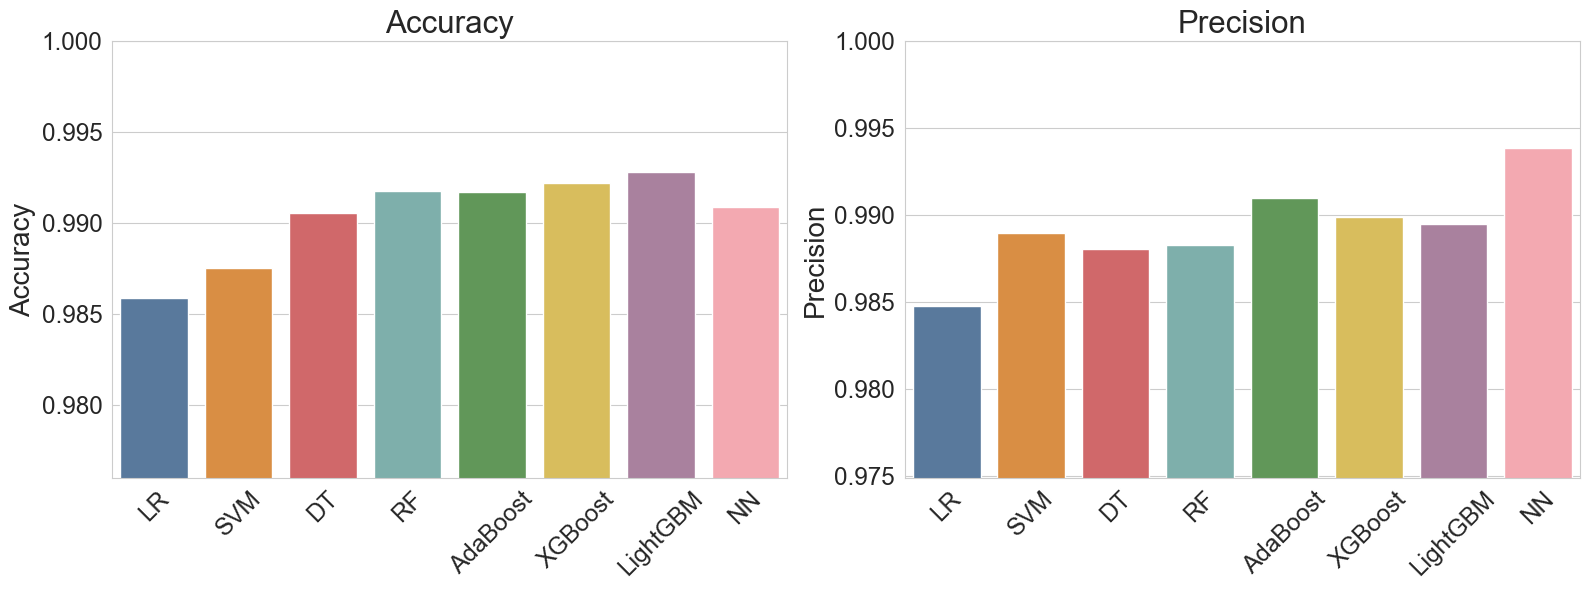

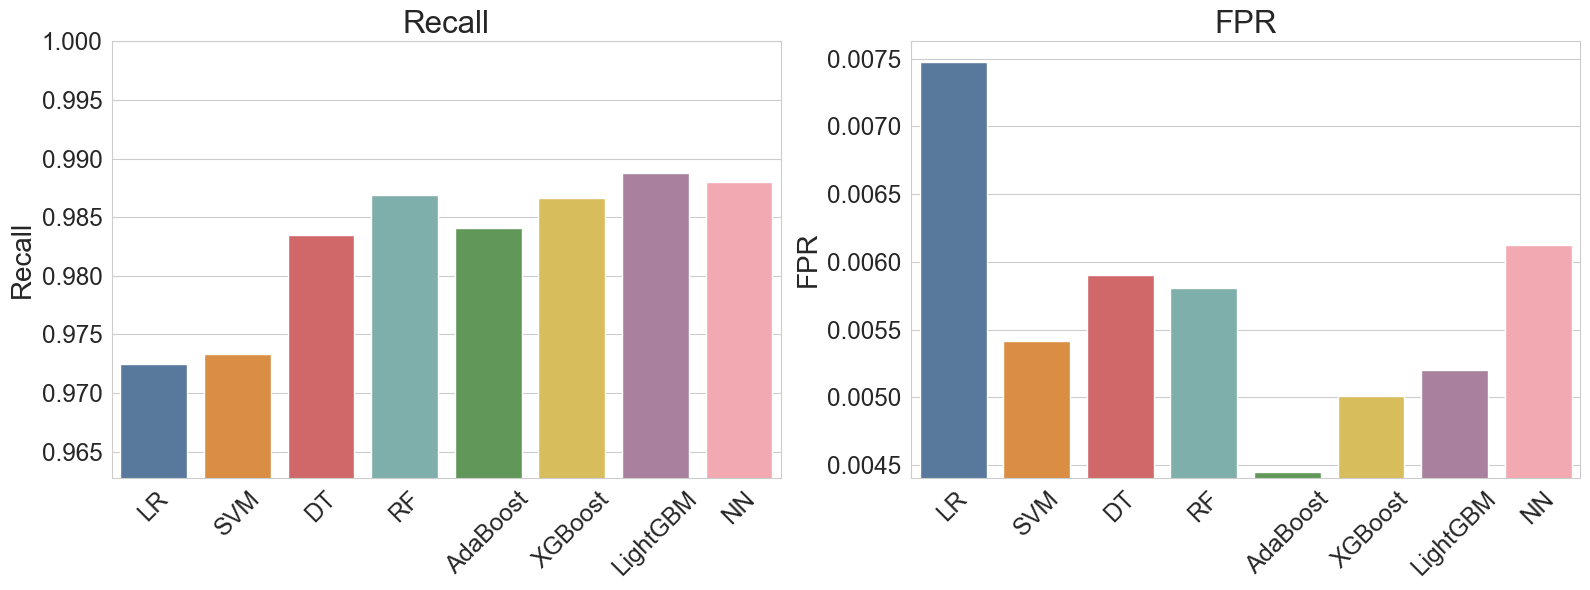

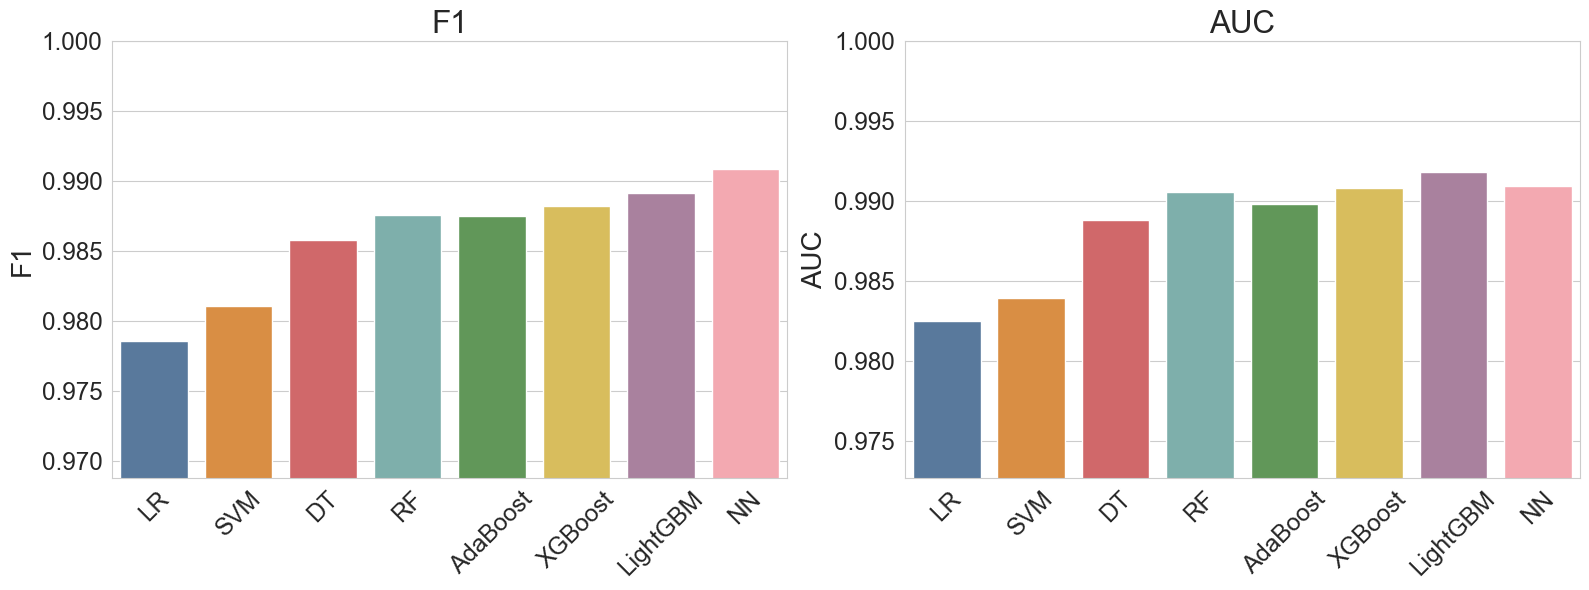

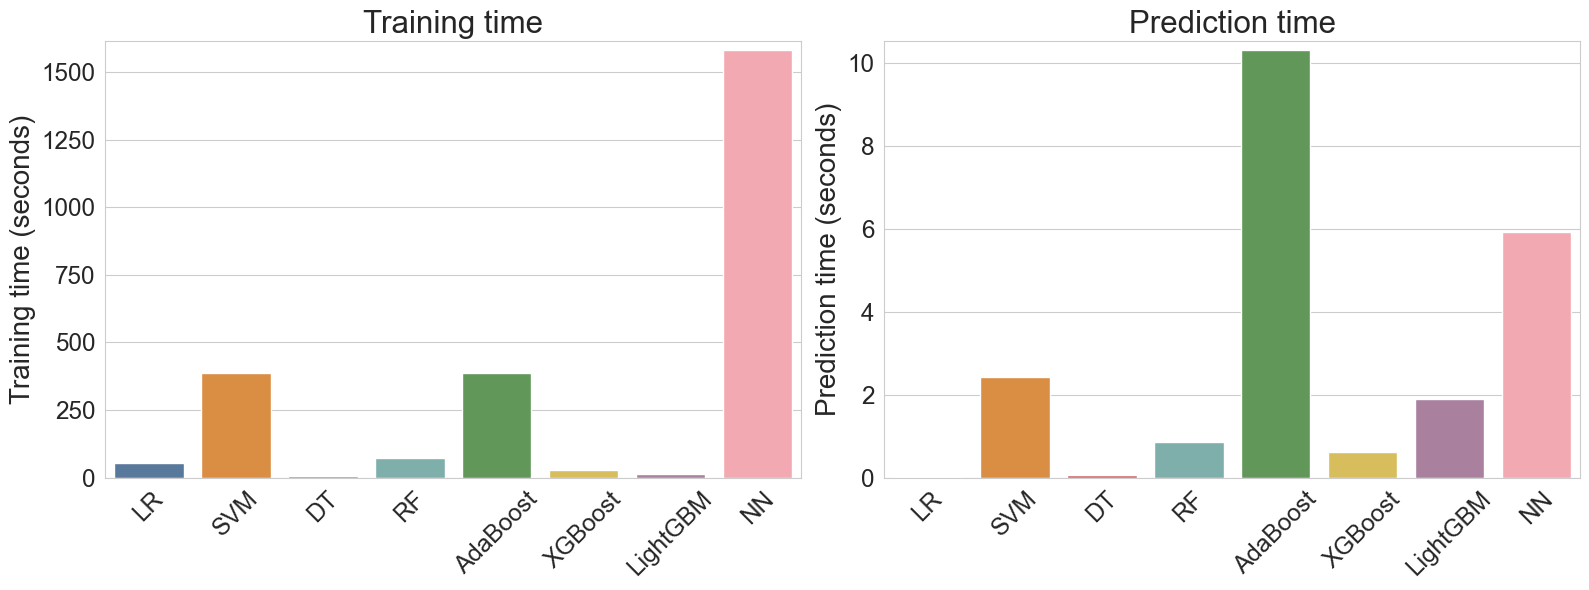

In [36]:
# Colors that are less bright and more subdued
import matplotlib.pyplot as plt
import seaborn as sns

subdued_colors = [
    "#4E79A7",
    "#F28E2B",
    "#E15759",
    "#76B7B2",
    "#59A14F",
    "#EDC948",
    "#B07AA1",
    "#FF9DA7",
]

# Assigning colors to each model
model_colors = {model: color for model,
                color in zip(mean_result_dict, subdued_colors)}

# Setting the y-axis limits for the metrics
# For metrics like FPR where the range is very small, we use the actual range
metric_ylims = {
    "Accuracy": (
        min([mean_result_dict[m]["Accuracy"] for m in classifiers]) * 0.99,
        1.00,
    ),
    "Precision": (
        min([mean_result_dict[m]["Precision"] for m in classifiers]) * 0.99,
        1.00,
    ),
    "Recall": (min([mean_result_dict[m]["Recall"] for m in classifiers]) * 0.99, 1.00),
    "FPR": (
        min([mean_result_dict[m]["FPR"] for m in classifiers]) * 0.99,
        max([mean_result_dict[m]["FPR"] for m in classifiers]) * 1.02,
    ),
    "F1": (min([mean_result_dict[m]["F1"] for m in classifiers]) * 0.99, 1.00),
    "AUC": (min([mean_result_dict[m]["AUC"] for m in classifiers]) * 0.99, 1.00),
    "Training time": (
        0,
        max([mean_result_dict[m]["Training time"]
            for m in classifiers]) * 1.02,
    ),
    "Prediction time": (
        0,
        max([mean_result_dict[m]["Prediction time"]
            for m in classifiers]) * 1.02,
    ),
}


def plot_metric_pairs(metric1, metric2, data, color_map, ylims):
    """
    Plots two metrics side by side in a single figure.

    Parameters:
    - metric1: The first metric to plot.
    - metric2: The second metric to plot.
    - data: The dictionary containing the data for each metric.
    - color_map: A dictionary mapping models to colors.
    - ylims: A dictionary containing y-axis limits for the metrics.
    """
    sns.set_style("whitegrid")  # Set the style to whitegrid

    fig, axes = plt.subplots(
        1, 2, figsize=(16, 6)
    )  # Adjust figure size for better visibility

    # Plot the first metric
    values1 = [data[model][metric1] for model in data.keys()]
    sns.barplot(x=list(data.keys()), y=values1, palette=color_map, ax=axes[0])
    axes[0].set_title(f"{metric1}", fontsize=18 * 1.25)
    axes[0].set_ylabel(
        f"{metric1}"
        + (" (seconds)" if metric1 in ["Training time", "Prediction time"] else ""),
        fontsize=16 * 1.25,
    )
    axes[0].set_ylim(*ylims[metric1])  # Unpack the tuple to set limits
    axes[0].tick_params(axis="x", rotation=45, labelsize=14 * 1.25)
    axes[0].tick_params(axis="y", labelsize=14 * 1.25)

    # Plot the second metric
    values2 = [data[model][metric2] for model in data.keys()]
    sns.barplot(x=list(data.keys()), y=values2, palette=color_map, ax=axes[1])
    axes[1].set_title(f"{metric2}", fontsize=18 * 1.25)
    axes[1].set_ylabel(
        f"{metric2}"
        + (" (seconds)" if metric2 in ["Training time", "Prediction time"] else ""),
        fontsize=16 * 1.25,
    )
    axes[1].set_ylim(*ylims[metric2])  # Unpack the tuple to set limits
    axes[1].tick_params(axis="x", rotation=45, labelsize=14 * 1.25)
    axes[1].tick_params(axis="y", labelsize=14 * 1.25)

    plt.tight_layout()
    plt.show()


# Plotting the pairs of metrics
plot_metric_pairs("Accuracy", "Precision", mean_result_dict,
                  model_colors, metric_ylims)
plot_metric_pairs("Recall", "FPR", mean_result_dict,
                  model_colors, metric_ylims)
plot_metric_pairs("F1", "AUC", mean_result_dict, model_colors, metric_ylims)
plot_metric_pairs(
    "Training time", "Prediction time", mean_result_dict, model_colors, metric_ylims
)